<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/FashionMnist_NoRegularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries/Dataset

### Import Libraries

In [1]:
import time
import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive

import pandas as pd
import numpy as np
import random as rd

from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
rd.seed(2020)         # Initialize the random number generator.
np.random.seed(2020)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2020)  # sets the graph-level random seed

### Import Dataset

Load dataset from TF

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

### Check GPU

In [4]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

gpu_lst = get_available_gpus()

if(len(gpu_lst) > 0):
  print("GPU Enabled")
else:
  print("GPU Disabled")

GPU Enabled


## Data Visualization

Plot at least one sample from each class of the dataset 

In [5]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

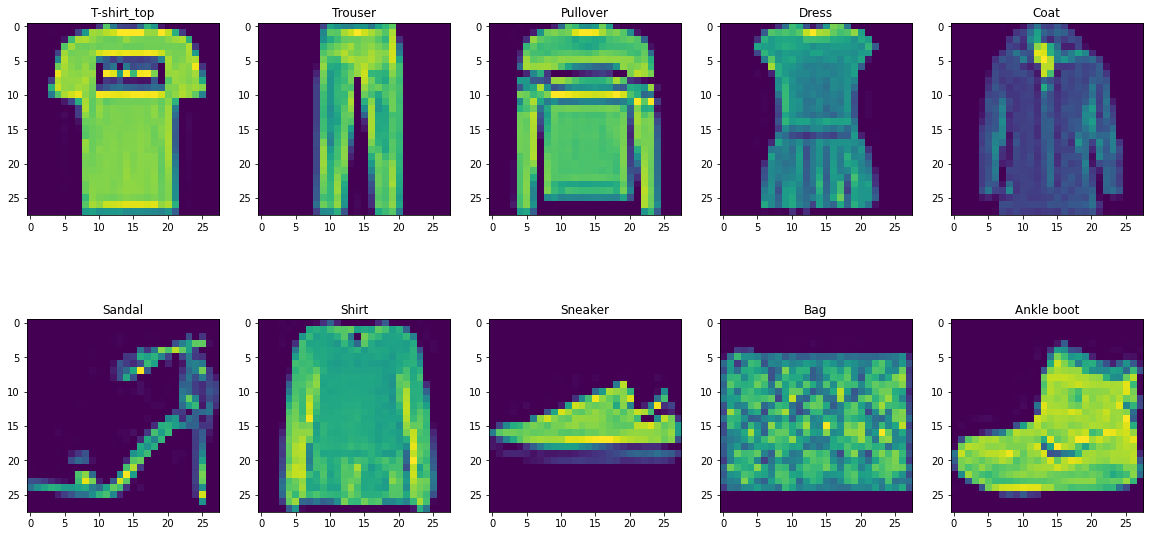

In [6]:
fig,ax = plt.subplots(2,5,figsize=(20,10))
j = 0
for c in enumerate(class_names):
  idx = [i for i,v in enumerate(y_train) if c[0] == v][0]
  row,col = j, c[0] % 5  
  ax[row,col].imshow(X_train[idx])
  ax[row,col].set_title(c[1])
  if c[0] % 5 == 4:
    j = j + 1

Print the shapes of train and test data

In [7]:
print("Train Feature Shape:",X_train.shape)
print("Train Label Shape:",y_train.shape)
print("Test Feature Shape:",X_test.shape)
print("Test Label Shape:",y_test.shape)

Train Feature Shape: (60000, 28, 28)
Train Label Shape: (60000,)
Test Feature Shape: (10000, 28, 28)
Test Label Shape: (10000,)


## Data Pre-processing 

Bring the train and test data in the required format

In [8]:
# Normalize the data
X_train = X_train.reshape((60000, 28*28))    # reshape the input set to size 28*28. VEctor of length 784
X_train = X_train.astype('float32')/255      # normalize to grayscale; set datatype as float32

X_test = X_test.reshape((10000, 28*28))      # reshape the input set to size 28*28. 
X_test = X_test.astype('float32')/255        # normalize to grayscale; set datatype as float32

y_train_enc = tf.keras.utils.to_categorical(y_train)
y_test_enc = tf.keras.utils.to_categorical(y_test)

In [9]:
#Shapes after reshaping & normalizing
print("Train Feature Shape:",X_train.shape)
print("Train Label Shape:",y_train.shape)
print("Test Feature Shape:",X_test.shape)
print("Test Label Shape:",y_test.shape)

Train Feature Shape: (60000, 784)
Train Label Shape: (60000,)
Test Feature Shape: (10000, 784)
Test Label Shape: (10000,)


## Model Building 

a.    Sequential Model layers- Use AT LEAST 3 dense layers with appropriate input for each. Choose the best number for hidden units and give reasons.<br>
b.   Add L2 regularization to all the layers.<br>
c.    Add one layer of dropout at the appropriate position and give reasons. <br>d.   Choose the appropriate activation function for all the layers.<br>
e.   Print the model summary


In [10]:
model = keras.models.Sequential()

# Layer 1 = input layer
# specify the input size for in the first layer.

model.add(keras.layers.Dense(512, activation='relu', input_shape= (28*28,)))

# Layer 2 = hidden layer  with Regularizers
model.add(keras.layers.Dense(300, activation='relu') )

# Add dropout of 50% to layer 2
model.add(keras.layers.Dropout(0.5))

# Layer 3 = hidden layer 
model.add(keras.layers.Dense(64, activation='relu') )

# Layer 4 = output layer
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               153900    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                19264     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 575,734
Trainable params: 575,734
Non-trainable params: 0
_________________________________________________________________


**Choose the best number for hidden units and give reasons.**<br>
1.The number of hidden neurons should be between the size of the input layer and the size of the output layer.<br>
2.The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.<br>
3.The number of hidden neurons should be less than twice the size of the input layer.<br>

Reference : [Link](https://www.heatonresearch.com/2017/06/01/hidden-layers.html)

Even though I  didn't completely followed the rules in the reference because the number of hidden layers is not more than 4 so wanted reduce the parameters to learn (will discuss about dropout next) before the output layer

**Give reasons for the dropout**<br>
Dropout of 0.5 is to drastically reduce the parameters and also generalize better on the unseen data points

## Model Compilation 

a.Compile the model with the appropriate loss function. - **categorical_crossentropy** - multiclass classification<br>
b.Use an appropriate optimizer - **Adam**.<br>
c.Use **accuracy** as metric.

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,name='Adam'),
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'] )

**Give reasons for the choice of learning rate and its value**<br>
Learning rate of 0.001 is choosen, because too high would rollover the minima and I have tried giving the higher learning rate like 0.4, 0.2, 0.1, 0.01 the loss doesn't seem to converge to minima, so decided to lower the learning rate further so that weight update is minimum and proceeds towards the convergence or global minima 

##Model Training 

In [12]:
start_train = time.time()
history = model.fit(X_train,
                    y_train_enc,
                    epochs=100,
                    batch_size=1000,
                    validation_split=0.2,
                    verbose=1)
end_train = time.time()

Epoch 1/100
48/48 [==============================] - 0s 9ms/step - loss: 0.8479 - accuracy: 0.7007 - val_loss: 0.4901 - val_accuracy: 0.8290
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.4766 - accuracy: 0.8310 - val_loss: 0.4042 - val_accuracy: 0.8553
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.4112 - accuracy: 0.8534 - val_loss: 0.3821 - val_accuracy: 0.8608
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.3739 - accuracy: 0.8643 - val_loss: 0.3507 - val_accuracy: 0.8751
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.3464 - accuracy: 0.8754 - val_loss: 0.3399 - val_accuracy: 0.8765
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.3305 - accuracy: 0.8808 - val_loss: 0.3336 - val_accuracy: 0.8807
Epoch 7/100
48/48 [==============================] - 0s 6ms/step - loss: 0.3116 - accuracy: 0.8865 - val_loss: 0.3293 - val_accuracy: 0.8794
Epoch 8/100
4

Print the total time taken for training

In [13]:
#Time taken to train
print("Time taken to train the NN:",end_train - start_train," seconds")

Time taken to train the NN: 29.516706705093384  seconds


Plot the loss and accuracy history graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


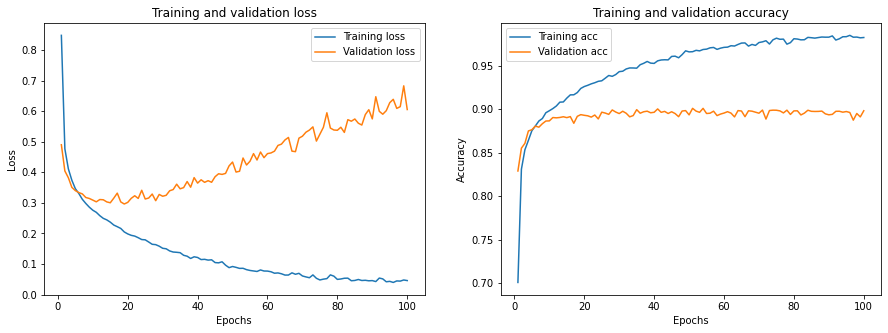

In [14]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fix,ax = plt.subplots(1,2, figsize=(15,5))
ax1 = ax[0] # to plot Training Loss
ax2 = ax[1] # to plot Training Accuracy
ax1.plot(epochs, loss, label='Training loss')
ax1.plot(epochs, val_loss,  label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, label='Training acc')
ax2.plot(epochs, val_acc,  label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

## Model Evaluation 

Print the final test/validation loss and accuracy

In [15]:
results = model.evaluate(X_test, y_test_enc)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.6983 - accuracy: 0.8933
Test Loss: 0.6983066201210022
Test Accuracy: 0.8932999968528748


In [16]:
#Predictions
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Confusion Matrix

In [17]:
df = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
df.head()
confusion_matrix = pd.crosstab(df['y_test'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted    0    1    2    3    4    5    6    7    8    9
Actual                                                     
0          831    2   21   19    3    0  118    0    6    0
1            4  981    2   11    0    0    1    0    1    0
2           22    1  814   11   87    0   64    0    1    0
3           22    5   11  894   40    1   22    0    5    0
4            2    1   71   25  835    0   64    0    2    0
5            1    0    0    1    0  965    0   19    1   13
6           90    2   80   36   69    0  717    0    6    0
7            0    0    0    0    0    8    0  972    0   20
8            4    0    3    2    5    2   12    4  968    0
9            0    0    0    1    0    7    1   35    0  956


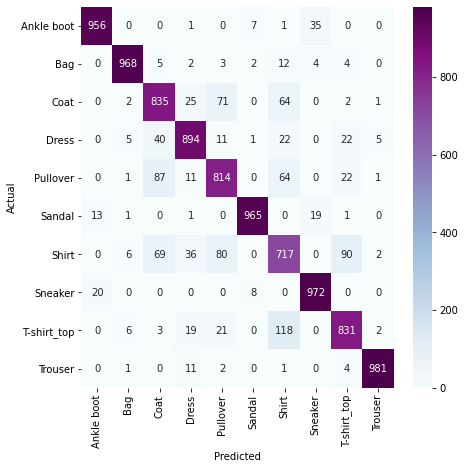

In [18]:
y_pred_cls = [class_names[v] for v in y_pred]
y_test_cls= [class_names[v] for v in y_test]

df = pd.DataFrame({'y_test':y_test_cls,'y_pred':y_pred_cls})
df.head()
confusion_matrix = pd.crosstab(df['y_test'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
# print(confusion_matrix)
fig, ax = plt.subplots(figsize=(7,7))     
sns.heatmap(confusion_matrix,annot=True,cmap='BuPu',fmt='d',ax=ax)

Classification Report

In [19]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.81      0.81      0.81      1000
           3       0.89      0.89      0.89      1000
           4       0.80      0.83      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.72      0.72      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Class 1,6,5,7,8,9

In [20]:
[(i,c) for i,c in enumerate(class_names) if i in [1,6,5,7,8,9]]

[(1, 'Trouser'),
 (5, 'Sandal'),
 (6, 'Shirt'),
 (7, 'Sneaker'),
 (8, 'Bag'),
 (9, 'Ankle boot')]

**Write a summary for the best and worst performing class and the overall trend.**<br>
Classes Trouser, Sandal, Sneaker, Bag and Ankle Boot are best performing classes compared to others from confusion matrix as well as from F1- Score, however some of it are performming better in this model, the worst one is Shirt because the T-Shirt and Shirt has lot of resemblance<br>
**With respect to trend**<br>
Even though the training loss is converging and training accuracy is increasing however validation accuracy attained its peak way before training in the epochs and saturated whereas validation loss suddenly surged as epochs increased